In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
import glob
import numpy as np

Get paths of all monthly index and generation files

In [2]:
path = os.path.join('Data storage', 'final state data', 'Monthly index*')
mi_fns = glob.glob(path)

In [3]:
path = os.path.join('Data storage', 'final state data', 'Monthly gen*')
mg_fns = glob.glob(path)

Combine all state monthly index files into a single dataframe

In [4]:
df_list = []
for f in mi_fns:
    state = f.split('.')[0][-2:]
    df = pd.read_csv(f)
    df['State'] = state
    df_list.append(df)
full_mi = pd.concat(df_list)
full_mi.reset_index(inplace=True, drop=True)
full_mi.rename(columns={'index (g/kWh)': 'monthly index (g/kWh)'}, inplace=True)
full_mi['datetime'] = pd.to_datetime(full_mi['datetime'])

In [5]:
full_mi.head()

,year,month,generation (MWh),final CO2 (kg),datetime,quarter,monthly index (g/kWh),change since 2005,index (lb/MWh),State
0,2001,1,590145.0,3.542602e+08,2001-01-01,1,600.293443,0.117946,1323.406924,AK
1,2001,2,546167.0,3.615468e+08,2001-02-01,1,661.971217,0.232810,1459.381744,AK
2,2001,3,587115.0,3.902535e+08,2001-03-01,1,664.696930,0.237886,1465.390852,AK
3,2001,4,488698.0,3.030298e+08,2001-04-01,2,620.075841,0.154787,1367.019200,AK
4,2001,5,484687.0,3.004285e+08,2001-05-01,2,619.840221,0.154348,1366.499750,AK


Combine all state monthly generation files into a single dataframe

In [6]:
df_list = []
for f in mg_fns:
    state = f.split('.')[0][-2:]
    df = pd.read_csv(f)
    df['State'] = state
    df_list.append(df)
full_mg = pd.concat(df_list)
full_mg.reset_index(inplace=True, drop=True)
full_mg['datetime'] = pd.to_datetime(full_mg['datetime'])

monthly_gen = pd.pivot_table(full_mg, index=['State', 'datetime'], 
                             values='generation (MWh)', columns='fuel category')
monthly_gen.reset_index(inplace=True, drop=False)
monthly_gen['Year'] = monthly_gen['datetime'].dt.year
monthly_gen.replace(np.nan, 0, inplace=True)

Merge the two dataframes to combine generation and index data

In [9]:
gen_index = pd.merge(monthly_gen, full_mi[['datetime', 'State', 'monthly index (g/kWh)']], 
                     on=['datetime', 'State'])
gen_index.head()

,State,datetime,Coal,Natural Gas,Nuclear,Other,Renewables,Year,monthly index (g/kWh)
0,AK,2001-01-01,46903.0,367521.0,0.0,71085.0,104636.0,2001,600.293443
1,AK,2001-02-01,54056.0,334016.0,0.0,67910.0,90185.0,2001,661.971217
2,AK,2001-03-01,51920.0,343858.0,0.0,91413.0,99924.0,2001,664.696930
3,AK,2001-04-01,37590.0,290050.0,0.0,76372.0,84686.0,2001,620.075841
4,AK,2001-05-01,40986.0,283468.0,0.0,75034.0,85199.0,2001,619.840221


Calculate variability as the rolling standard deviation of monthly values. Also calculate a normalized value, which divides the rolling standard deviation by the rolling average.

In [11]:
for state in gen_index['State'].unique():
    gen_index.loc[gen_index['State'] == state, 'Index variability'] = \
        gen_index.loc[gen_index['State']==state, 
                       'monthly index (g/kWh)'].rolling(window=12).std()
    
    gen_index.loc[gen_index['State'] == state, 
                   'Normalized Index variability'] = \
         gen_index.loc[gen_index['State']==state, 'Index variability'] / \
         gen_index.loc[gen_index['State']==state, 
                       'monthly index (g/kWh)'].rolling(window=12).mean()
gen_index.tail()

,State,datetime,Coal,Natural Gas,Nuclear,Other,Renewables,Year,monthly index (g/kWh),Index variability,Normalized Index variability
9745,WY,2016-11-01,3136243.00,61286.95,0.0,40986.67,414531.36,2016,916.315369,17.668906,0.019208
9746,WY,2016-12-01,3952815.25,64950.50,0.0,38877.40,583667.43,2016,891.854330,19.201913,0.020905
9747,WY,2017-01-01,3875156.57,72746.85,0.0,45655.70,358419.99,2017,956.145267,22.000973,0.023889
9748,WY,2017-02-01,3140221.06,55896.80,0.0,42111.49,409344.56,2017,925.869631,21.677007,0.023501
9749,WY,2017-03-01,2970256.83,60934.81,0.0,41061.12,502269.26,2017,912.486445,21.853026,0.023716


Add in the percent of generation from each fuel type, and the change in generation from that fuel type since the average in 2001. Maybe change from 2001 to a different year?

In [12]:
base_year = 2005

In [13]:
fuels = ['Coal', 'Natural Gas', 'Renewables', 'Nuclear', 'Other']
gen_index['Total gen'] = gen_index.loc[:, fuels].sum(axis=1)
for fuel in fuels:
    # New columns that are being added
    col_percent = 'percent ' + fuel
    col_change = 'change in ' + fuel

    # Calculate percent of generation from each fuel type
    gen_index[col_percent] = gen_index.loc[:, fuel] / gen_index.loc[:, 'Total gen']

    # Percent of fuel in state in base year (entire year)
    for state in gen_index['State'].unique():
        percent_fuel_base = gen_index.loc[(gen_index['Year'] == base_year) & 
                                          (gen_index['State'] == state), fuel].sum() / gen_index.loc[(gen_index['Year'] == 2001) & 
                                                                                                     (gen_index['State'] == state), 'Total gen'].sum()

        # Use percent of fuel in 2001 to calculate change for each state/month
        gen_index.loc[gen_index['State'] == state, 
                      col_change] = (gen_index.loc[gen_index['State'] == state, col_percent] - percent_fuel_base) / percent_fuel_base
    
# Change in variability compared to average base year value
for state in gen_index['State'].unique():
    norm_variability_base = gen_index.loc[(gen_index['Year'] == base_year) & 
                                  (gen_index['State'] == state), 'Normalized Index variability'].mean()
    variability_base = gen_index.loc[(gen_index['Year'] == base_year) & 
                                  (gen_index['State'] == state), 'Index variability'].mean()
    
    gen_index.loc[gen_index['State'] == state, 
                  'change in variability'] = (gen_index.loc[gen_index['State'] == state, 
                                                            'Index variability'] - variability_base) / variability_base
    
    gen_index.loc[gen_index['State'] == state, 
                  'change in norm variability'] = (gen_index.loc[gen_index['State'] == state, 
                                                            'Normalized Index variability'] - norm_variability_base) / norm_variability_base

Plot the change in variability since 2005 against the change in each fuel type

In [68]:
gen_index.columns

Index([u'State', u'datetime', u'Coal', u'Natural Gas', u'Nuclear', u'Other',
       u'Renewables', u'Year', u'monthly index (g/kWh)', u'Index variability',
       u'Normalized Index variability', u'Total gen', u'percent Coal',
       u'change in Coal', u'percent Natural Gas', u'change in Natural Gas',
       u'percent Renewables', u'change in Renewables', u'percent Nuclear',
       u'change in Nuclear', u'percent Other', u'change in Other',
       u'change in variability', u'change in norm variability'],
      dtype='object')

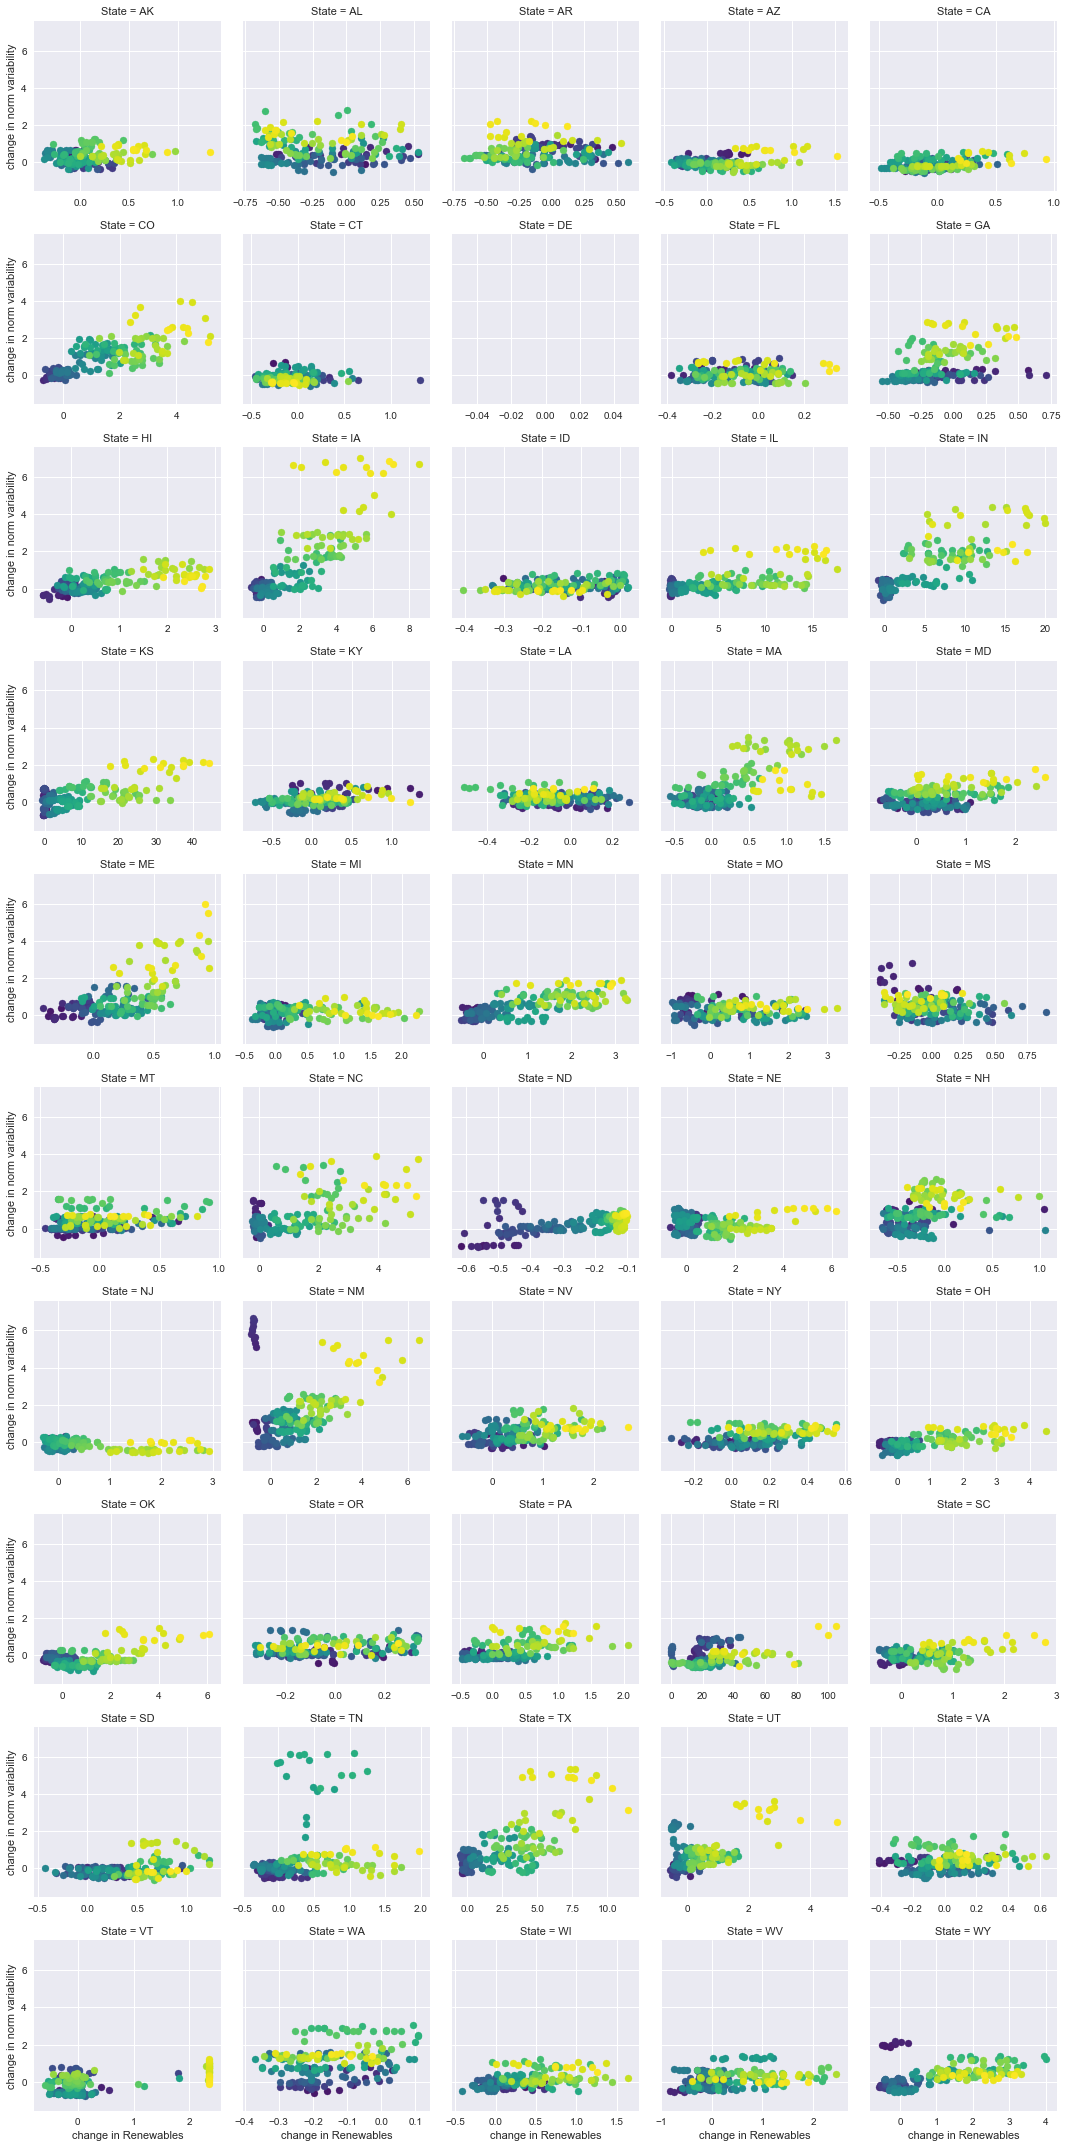

In [29]:
g = sns.FacetGrid(gen_index, col='State', col_wrap=5, sharex=False, 
                  hue='datetime', palette='viridis')
g.map(plt.scatter, 'change in Renewables', 'change in norm variability')

In [18]:
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.plotting import *
from bokeh.layouts import gridplot
from bokeh.models import HoverTool
from bokeh.palettes import viridis

In [26]:
output_notebook()

Loading BokehJS ...

In [28]:
figs = {}


for state in gen_index['State'].unique():
    temp = gen_index.loc[gen_index['State'] == state]
    colors = viridis(len(data))
    
    source = ColumnDataSource(data=dict(
        x=temp['change in Renewables'],
        y=temp['change in norm variability'],
        datetime=temp['datetime'],
        colors= viridis(len(temp))
    ))
    
    hover = HoverTool(
                        tooltips=[
                                ("(x,y)", "($x, $y)"),
                                ("datetime", "@datetime{%F}")],
                     formatters={
        'datetime'      : 'datetime', # use 'datetime' formatter for 'date' field
    }
                     )
    hover.point_policy = "snap_to_data"

    figs[state] = figure(title=state, tools=[hover])
    figs[state].circle('x', 'y', source=source, color='colors')
    figs[state].xaxis.axis_label = 'Change in Renewables'
    figs[state].yaxis.axis_label = 'Change in norm variability'

plots = figs.values()
grid = gridplot(plots, ncols=5, plot_width=250, plot_height=250)

show(grid)

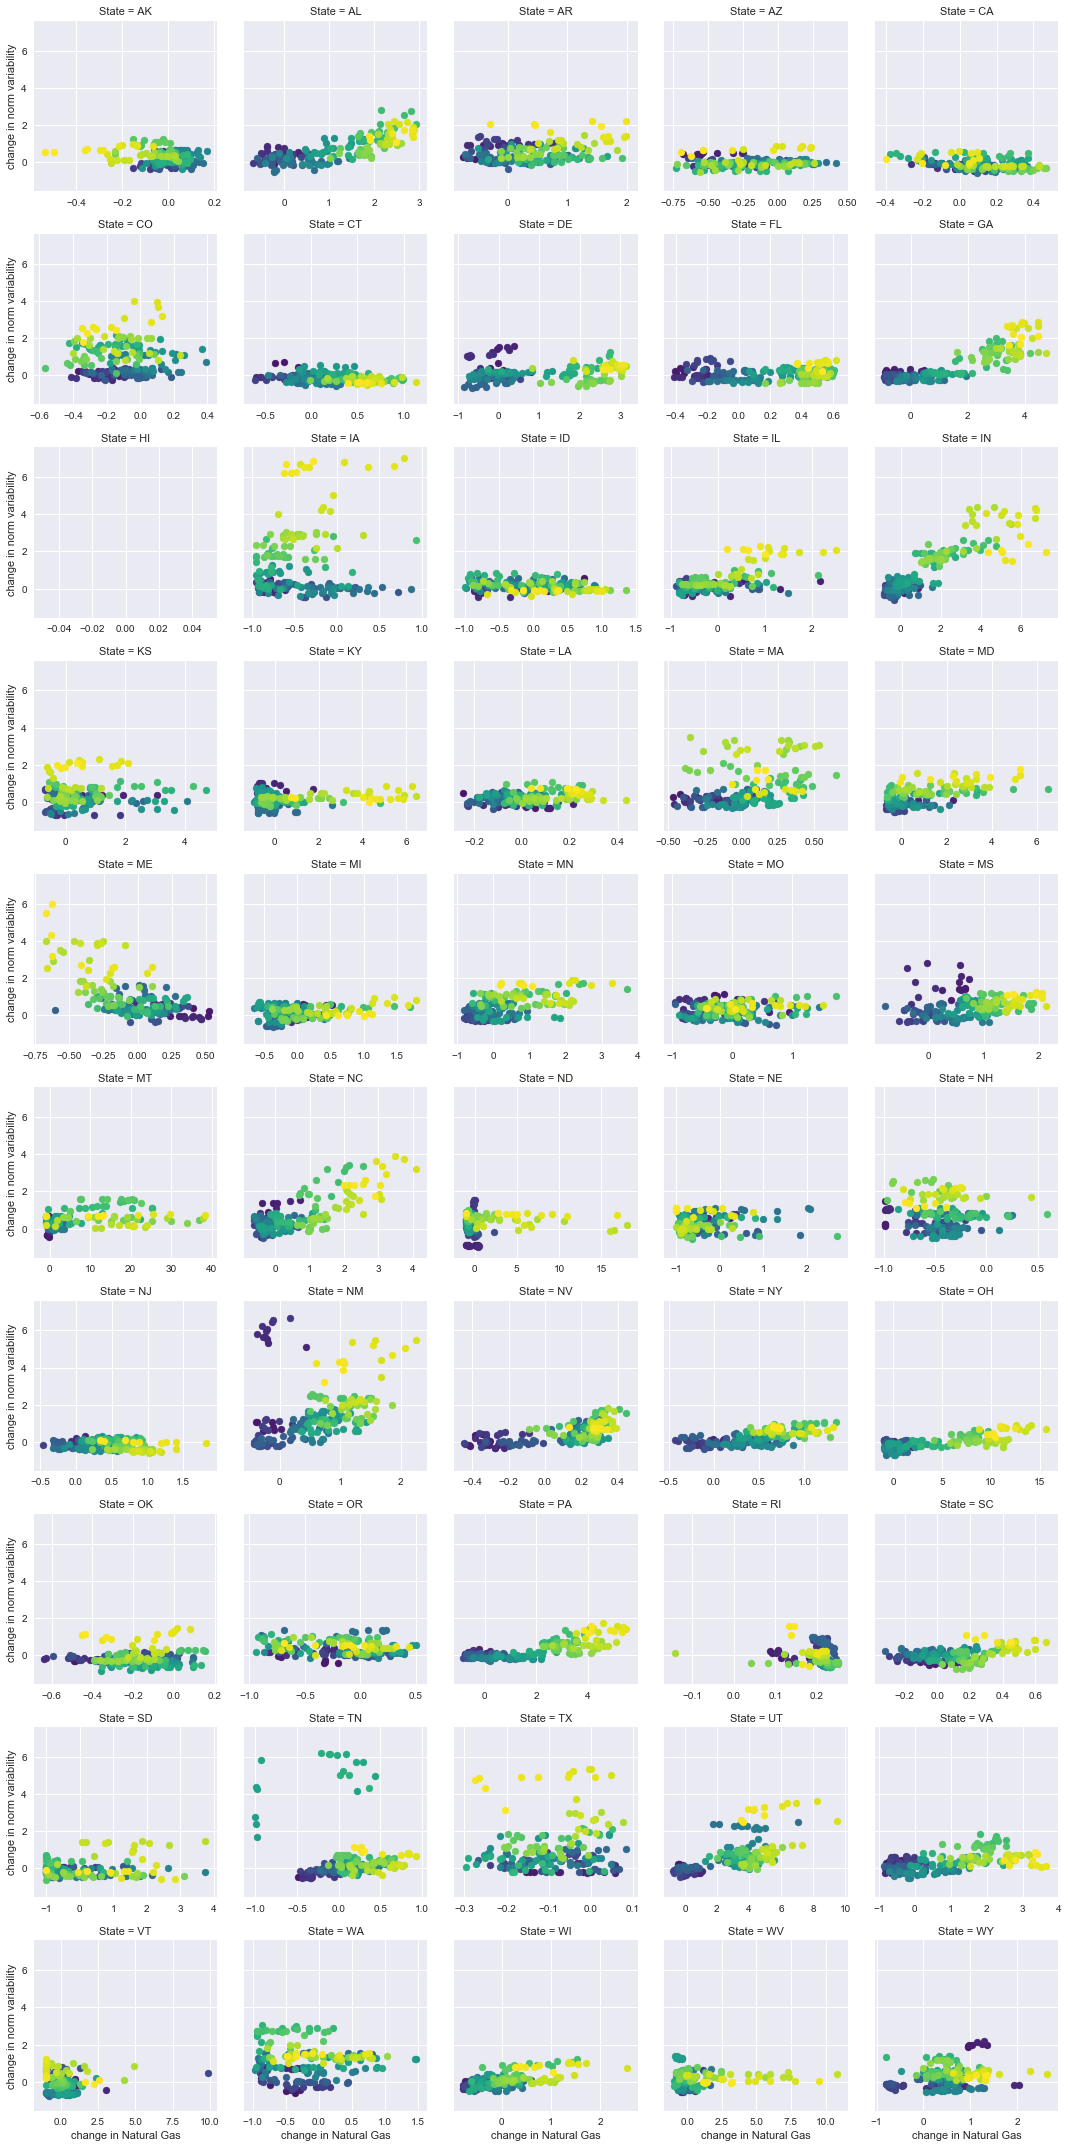

In [30]:
g = sns.FacetGrid(gen_index, col='State', col_wrap=5, sharex=False, 
                  hue='datetime', palette='viridis')
g.map(plt.scatter, 'change in Natural Gas', 'change in norm variability')